# Introduction to SoccerTrack

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](ここに以下の書式でURLを入れる) 
[![github](https://badgen.net/badge/:status/View%20On%20Github/black?icon=github&label)](https://github.com/AtomScott/SoccerTrack)
[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=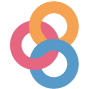)](https://)

---

This quick tutorial introduces the key concepts and basic features of SoccerTrack to help you get started with your projects.

## Concepts

### Multiple Object Tracking in SoccerTrack

In a broad definition, Multiple Object Tracking (MOT) is the problem of automatically identifying multiple objects in a video and representing them as a set of trajectories. 

The typical approach to MOT algorithms follows the tracking-by-detection paradigm, which attempts to solve the problem by first detecting objects in each frame and then associating them with the objects in the previous frame.

One large challenge in the tracking-by-detection paradigm is scalability. The detection model is typically a deep learning model, which is computationally expensive. The association model is also computationally expensive, as it requires reID features to be extracted for each bounding box. Recent approaches, such as [TrackFormer](https://arxiv.org/abs/2101.02702)/[TransTrack](https://arxiv.org/abs/2012.15460), have attempted to address this challenge by using a single deep learning model to perform both detection and association. However, there is no clear consensus on the best approach to MOT as tracking-by-detection models are still competitive ([ByteTrack](https://arxiv.org/abs/2110.06864)/[BoT-SORT](https://arxiv.org/abs/2206.14651)/[Strong-SORT](https://arxiv.org/abs/2202.13514)).


> IMHO, approaches that adhere to “The Bitter Lesson” are the most promising. [Unicorn: Towards Grand Unification of Object Tracking](https://arxiv.org/abs/2207.07078) demonstrates that a single network can solve four tracking problems (SOT, MOT, VOS, MOTS) simultaneously. I think this is a direction many will follow.

SoccerTrack implements the tracking-by-detection paradigm. 

In brief, the algorithm works as follows:

1. The detection model (YOLOX, DETR, RCNN etc.) detects items of interest via bounding boxes in each frame, then 
2. Several feature extractors are used to obtain descripters of each detection (e.g. ReID features, optical flow features, etc.), then
3. The association model (Minimum cost bipartite matching) associates detections in the current frame with detections in the previous frame / existing tracklets.

For a more detailed explanation of the tracking-by-detection paradigm, please refer to the original [DeepSORT paper](https://arxiv.org/abs/1703.07402), [this blog](https://medium.com/augmented-startups/deepsort-deep-learning-applied-to-object-tracking-924f59f99104) explaining DeepSORT or our [SoccerTrack paper](https://openaccess.thecvf.com/content/CVPR2022W/CVSports/papers/Scott_SoccerTrack_A_Dataset_and_Tracking_Algorithm_for_Soccer_With_Fish-Eye_CVPRW_2022_paper.pdf).

![](assets/tracking-by-detection.png)

We chose to start with this approach for two reasons: 1) it is a simple and modular approach and 2) we can explicitly control the use of appearance and motion features. 

### SoccerTrack DataFrame

SoccerTrack extends the popular data science library [pandas](https://pandas.pydata.org/) by adding an interface to handle tracking data. If you are not familiar with [pandas](https://pandas.pydata.org/), we recommend taking a quick look at its [Getting started](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) documentation before proceeding.

There are two core data structures in SoccerTrack, the BoundingBoxDataFrame and the CoordinateDataFrame. Both are,

   1. Subclasses of pandas.DataFrame and inherit all of its functionality
   2. Inherited from the SoccerTrackMixin and are designed to work with the SoccerTrack API

![](./assets/dataframe_inheritance.png)

The main difference is that the CoordinateDataFrame has comes built-in with functionality that handles coordinates, while the BoundingBoxDataFrame is made to be compatibile with bounding box data. Other than that, they are similar and can be approximately transformed into each other using the `to_coordinates` and `to_bounding_boxes` methods. However, a HomoGraphy is required to perform this transformation. See how to obtain a Homography in the [Camera Calibration]() tutorial.

In a nutshell, both data structures are a multi-indexed pandas.DataFrame with a few extra methods and attributes/metadata. 

![soccertrack_dataframe](./assets/soccertrack_dataframe.png)

Let’s see how some of these concepts work in practice.

## Reading and writing files

First, we need to read some data.

### Reading files

Assuming you have a file containing either bounding box or coordinates data, you can read it using `soccertrack.read_data()`, which automatically detects the filetype and creates a `BBoxDataFrame` or a `CoordinateDataFrame`. This tutorial uses a sample from the SoccerTrack dataset, which is part of the SoccerTrack installation. Therefore, we use `soccertrack.datasets.get_path()` to retrieve the path to the dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import soccertrack
from soccertrack.logger import show_df # This just makes the df viewable in the notebook.


dataset_path = soccertrack.datasets.get_path("top_view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]

bbdf = soccertrack.load_df(path_to_csv)

print(type(bbdf))
show_df(bbdf.head())

<class 'soccertrack.dataframe.bboxdataframe.BBoxDataFrame'>


To use the full soccertrack dataset, see ["Dataset Preparation"](../../01_get_started/dataset_preparation.html).

### Writing files

To write back to file use `BBoxDataFrame.to_csv()`. 

In [3]:
%%script false --no-raise-error # comment out this line to run this cell

bbdf.to_csv("soccertrack_sample.csv")

## Simple accessors and methods

Since the `BBoxDataFrame` and `CoordinateDataFrame` are subclasses of `pandas.DataFrame`, they inherit all of its functionality. This means that you can use all of the standard `pandas.DataFrame` methods and accessors. 

For example,

* `df.head()` returns the first 5 rows of the dataframe
* `df.columns` returns the column names
* `df.iloc[0]` returns the first row of the dataframe

In [4]:
# bbdf.head() is used above!

print(bbdf.columns[0])

show_df(bbdf.iloc[[0]])

('0', '0', 'bb_height')


## `xs` - Cross-section

Note that these are MultiIndex dataframes, so you can use more advanced indexing methods, such as `df.xs`.

In this example, 

* df.xs('0', level='TeamID', axis=1) returns the first team's data
* df.xs('5', level='PlayerID', axis=1) returns the data for player 5 in all teams
* df.xs(('0', '5'), level=('TeamID', 'PlayerID'), axis=1) returns the data for player 5 in team 0

In [5]:
show_df(bbdf.xs('0', level='TeamID', axis=1).head(3))

In [6]:
show_df(bbdf.xs('5', level='PlayerID', axis=1).head(3))

In [7]:
show_df(bbdf.xs(('0', '5'), level=('TeamID', 'PlayerID'), axis=1).head(3))

Attributes,bb_height,bb_left,bb_top,bb_width,conf
frame,,,,,
1,39.000000,1857.000000,1305.000000,39.000000,1.000000
2,39.000000,1858.000000,1304.250000,39.000000,1.000000
3,39.000000,1859.000000,1303.500000,39.000000,1.000000


## `loc` - MultiIndex slicing

MultiIndex slicing is a powerful tool for selecting data. Using the `slice(None)` object, you can select all data for a given index level. Although it's a little verbose, it's a very powerful tool once you get used to it.

In this example,

* df.loc[:, ('0', slice(None))] returns the data for team 0
* df.loc[:, (slice(None), '5')] returns the data for team 0 player 5 in all teams
* df.loc[:, (slice(None), slice(None), 'x')] returns the x coordinates for all players in all teams

In [8]:
# Select all the columns from TeamID 0
show_df(bbdf.loc[:, '0'].head(3))

In [9]:
# Select all the columns from TeamID 0 and PlayerID 5
show_df(bbdf.loc[:, ('0', '5')].head(3))

Attributes,bb_height,bb_left,bb_top,bb_width,conf
frame,,,,,
1,39.000000,1857.000000,1305.000000,39.000000,1.000000
2,39.000000,1858.000000,1304.250000,39.000000,1.000000
3,39.000000,1859.000000,1303.500000,39.000000,1.000000


In [10]:
# Select all the columns containg `bb_left` in the name
show_df(bbdf.loc[:, (slice(None), slice(None), 'bb_left')].head(3))

### Iterators

Both `BBoxDataFrame` and `CoordinateDataFrame` have several iterators that allow you to iterate over the data in different ways. 

* `df.iter_frames()` iterates over the data frame by frame
* `df.iter_teams()` iterates over the data frame by team
* `df.iter_players()` iterates over the data frame by player
* `df.iter_attributes()` iterates over the data frame by attribute

See the API documentation for more details.

In [11]:
for player_idx, player_df in bbdf.iter_players(drop=False):
    print(player_idx)
    show_df(player_df.head(3))
    break

('0', '0')


### Visualizing the results

Now that we have a bounding box dataframe, we can visualize the results.

In [12]:
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

It is also possible to download full soccertrack dataset using `soccertrack.datasets.Downloader`. See ["Dataset Preparation"](./dataset_preparation.html) for more details.

The `BBoxDataFrame` has a built-in `visualize_frame()` method that can be used to visualize the bounding boxes in a single frame.

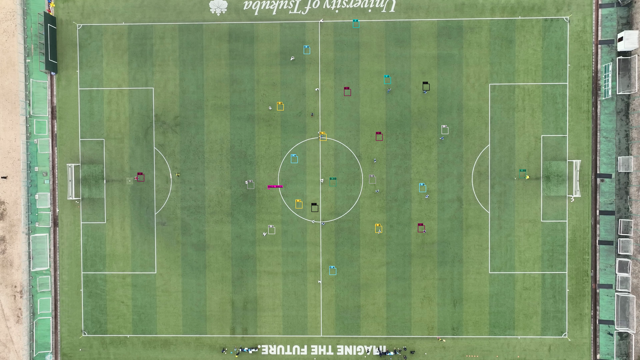

In [13]:
from soccertrack import Camera
from soccertrack.utils import cv2pil

frame_idx = 50
cam = Camera(path_to_mp4)
frame = cam.get_frame(frame_idx)
cv2pil(bbdf.visualize_frame(frame_idx=frame_idx, frame=frame)).resize((640, 360))

The `BBoxDataFrame` also has a `visualize_bbox()` method built in. It returns  generators containing a sequence of drawn bounding boxes, which can be passed to the `make_video` method of `soccertrack.utils` to output a video. 

The following notebook will output `bbox_FISH.mp4` in the current directory.

In [14]:
save_path = 'assets/visualize_frames.mp4'
bbdf_short = bbdf.iloc[:50].copy()
bbdf_short.visualize_frames(path_to_mp4, save_path)

Writing video: 50it [00:16,  3.00it/s]


## Tracking

Below we provide a snippiet of code that detects and tracks the players and ball in the downloaded video. First we define the components of our tracking pipeline. In SoccerTrack, there are six core components:

- `Camera` - A class that handles camera calibration and coordinate transformations
- `detection_model`: A detection model, such as YOLOX, DETR, etc. 
- `image_model`:　An image feature extraction model, such as ResNet or OSNet.
- `SingleObjectTracker`: Used to track a single object.
- `MultiObjectTracker`: Used to track multiple objects.
- `MotionVisualMatchingFunction` and CMMs (Cost Metric Matrices): Defines a way to match tracks and boundin boxes. 


> Deciding how to architect the structure of the tracking part was very tricky and probably suboptimal. We are still working on improving this part of the library so there may be some breaking changes in the future.

In [15]:
from soccertrack import Camera, detection_model
from soccertrack.utils import get_git_root
from soccertrack.tracking_model.matching import MotionVisualMatchingFunction
from soccertrack.metrics import EuclideanCMM, CosineCMM
from soccertrack.tracking_model import MultiObjectTracker, SingleObjectTracker
from soccertrack.image_model import ImageEmbedder

root = get_git_root()
cam = Camera(path_to_mp4)

"""
# Define the object detection model
Here we use a pretrained yolov5x model finetuned on top-view video data
"""
model_name = "yolov5"
model_repo = root / "external" / "yolov5"
model_ckpt = root / "models" / "yolov5" / "yolov5x_last.pt"
det_model = detection_model.load(model_name, model_repo, model_ckpt)
det_model.model.conf = 0.5
det_model.model.size = 1920

"""
# Define the Image Embedding model
The embedding model outputs vectors describing the image features of each detected bounding box.
Here we use the final layers of a pretrained ResNet18 model finetuned to classify each bounding box into either the home-team or away-team.
"""
dirpath = root / "models" / "resnet18"
ckpt_path = list(dirpath.glob("*.ckpt"))[-1]
image_model = ImageEmbedder.load_from_checkpoint(ckpt_path, num_classes=2)

"""
# Define the SingleObjectTracker model
The SingleObjectTrack models the motion of each sequence of bounding boxes (e.g. tracks). For this example, we use the simplest motion model and assume no movement (which is of course not optimal).
"""
sot_tracker = SingleObjectTracker
sot_tracker_kwargs = {}

"""
# Define the matching method and distance metrics
"""
matching_fn = MotionVisualMatchingFunction(
    motion_metric=EuclideanCMM(),
    motion_metric_beta=0.95,
    motion_metric_gate=0.5,
    visual_metric=CosineCMM(),
    visual_metric_beta=1 - 0.95,
    visual_metric_gate=0.3,
)

"""
# Finally, set up the MultiObjectTracker
"""
tracker = MultiObjectTracker(
    detection_model=det_model,
    image_model=image_model,
    tracker=sot_tracker,
    tracker_kwargs=sot_tracker_kwargs,
    matching_fn=matching_fn,
)

YOLOv5 🚀 v6.2-239-gf33718f Python-3.10.9 torch-1.13.1 CPU

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients
Adding AutoShape... 
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../models/resnet18/epoch=epoch=0-val_accval_acc=0.98.ckpt`


In [18]:
%%script false --no-raise-error # comment out this line to run this cell

from soccertrack.logger import set_log_level

set_log_level('ERROR')

tracker.track(cam)
pred = tracker.to_bbdf()

save_path = "tracking_results.mp4"
pred.visualize_frames(cam.video_path, save_path)
# Video(save_path) un-comment this to show the video in this notebook!

## What next?

> This tutorial is a work in progress. If you have any questions or suggestions, please feel free to [reach out](https://twitter.com/AtomJamesScott).
> 
> We were heavily inspired by the wonderful [GeoPandas](https://geopandas.org/) documentation. Kudos to the GeoPandas team for their great work!